# 02 - Lyrics NLP & Originality Scoring
## Grammy Song of the Year 2026 Prediction

This notebook analyzes lyrics using NLP to compute:
- Lyric originality scores (how different from past winners)
- Vocabulary richness metrics
- Semantic embedding analysis

In [24]:
import sys
sys.path.insert(0, '../src')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

from data_sources import SONG_UNIVERSE, HISTORICAL_GRAMMY_WINNERS
from feature_engineering import LyricOriginalityScorer

print("Imports successful!")

Imports successful!


## 1. Load Collected Data

In [25]:
# Load all data from previous notebook
data_dir = Path('../data')

with open(data_dir / 'all_data.json', 'r') as f:
    all_data = json.load(f)

print(f"Loaded data for {len(all_data)} songs")
for song, data in all_data.items():
    lyrics_len = len(data['lyrics']['lyrics'])
    print(f"  • {song} - {lyrics_len} chars")

Loaded data for 8 songs
  • Golden - 1058 chars
  • APT. - 2511 chars
  • WILDFLOWER - 2044 chars
  • Abracadabra - 2188 chars
  • luther - 2621 chars
  • Manchild - 2160 chars
  • Anxiety - 3124 chars
  • DtMF - 2640 chars


In [26]:
!pip install sentence-transformers

## 2. Initialize NLP Engine

In [27]:
# Initialize the lyric originality scorer

# Initialize the lyric originality scorer
scorer = LyricOriginalityScorer()
print("Lyric Originality Scorer initialized.")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Loaded sentence transformer: all-MiniLM-L6-v2
Lyric Originality Scorer initialized.


## 3. Basic Lyrics Analysis

In [28]:
# Analyze basic lyrics metrics
lyrics_analysis = []

for song_name, song in all_data.items():
    lyrics = song['lyrics']['lyrics']
    words = lyrics.lower().split()
    unique_words = set(words)
    
    lyrics_analysis.append({
        'Song': song_name,
        'Word Count': len(words),
        'Unique Words': len(unique_words),
        'Vocabulary Richness': round(len(unique_words) / max(len(words), 1), 3),
        'Avg Word Length': round(np.mean([len(w) for w in words]), 2) if words else 0,
        'Line Count': song['lyrics']['line_count']
    })

lyrics_df = pd.DataFrame(lyrics_analysis)
print("Basic Lyrics Analysis:")
display(lyrics_df)

Basic Lyrics Analysis:


,Song,Word Count,Unique Words,Vocabulary Richness,Avg Word Length,Line Count
0,Golden,200,67,0.335,4.29,1
1,APT.,467,183,0.392,4.35,1
2,WILDFLOWER,388,202,0.521,4.26,1
3,Abracadabra,350,167,0.477,5.22,1
4,luther,491,221,0.450,4.26,1
5,Manchild,380,188,0.495,4.67,1
6,Anxiety,581,195,0.336,4.36,1
7,DtMF,514,266,0.518,4.13,1


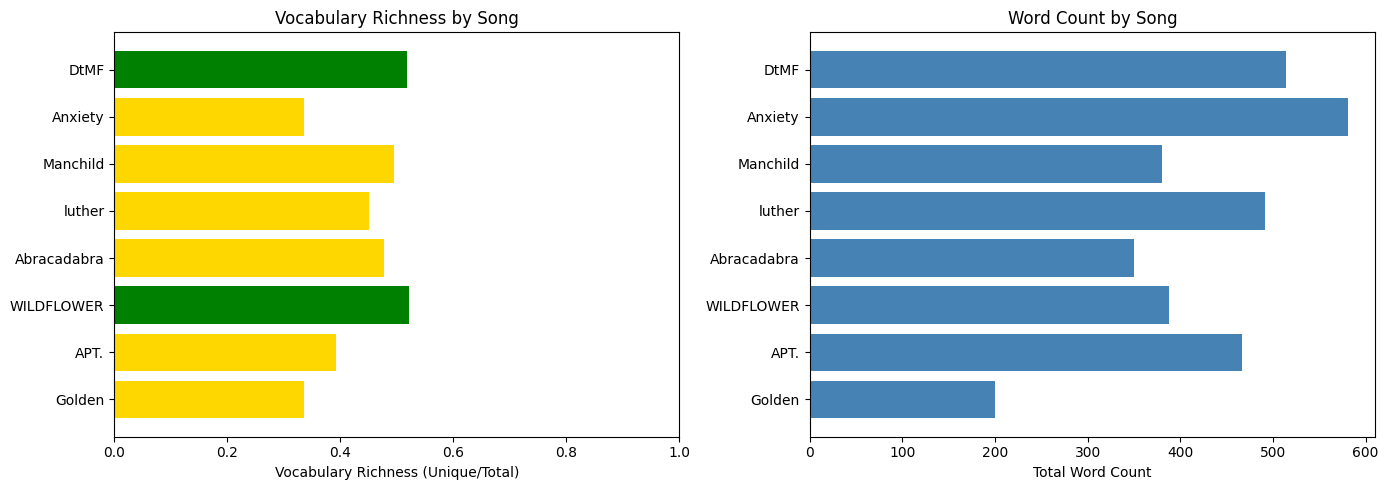

In [29]:
# Visualize vocabulary richness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vocabulary richness
ax = axes[0]
songs = lyrics_df['Song'].tolist()
richness = lyrics_df['Vocabulary Richness'].tolist()
colors = ['green' if r > 0.5 else 'gold' if r > 0.3 else 'red' for r in richness]
ax.barh(songs, richness, color=colors)
ax.set_xlabel('Vocabulary Richness (Unique/Total)')
ax.set_title('Vocabulary Richness by Song')
ax.set_xlim(0, 1)

# Word count
ax = axes[1]
word_counts = lyrics_df['Word Count'].tolist()
ax.barh(songs, word_counts, color='steelblue')
ax.set_xlabel('Total Word Count')
ax.set_title('Word Count by Song')

plt.tight_layout()
plt.savefig('../data/lyrics_basic_analysis.png', dpi=150)
plt.show()

## 4. Compute Originality Scores

In [30]:
# Prepare lyrics data for scoring
lyrics_dict = {song: data['lyrics'] for song, data in all_data.items()}

# Compute originality scores
print("Computing lyric originality scores...")
originality_scores = scorer.score_all_songs(lyrics_dict)

print("\nOriginality Scores:")
for song, scores in originality_scores.items():
    print(f"  {song}: {scores['lyric_originality_score']:.3f}")

Computing lyric originality scores...

Originality Scores:
  Golden: 0.849
  APT.: 0.767
  WILDFLOWER: 0.745
  Abracadabra: 0.757
  luther: 0.747
  Manchild: 0.711
  Anxiety: 0.728
  DtMF: 0.775


In [31]:
# Create originality DataFrame
orig_data = []
for song, scores in originality_scores.items():
    orig_data.append({
        'Song': song,
        'Originality Score': round(scores['lyric_originality_score'], 3),
        'Historical Distance': round(scores.get('historical_distance', 0.5), 3),
        'Peer Distance': round(scores.get('peer_distance', 0.5), 3)
    })

orig_df = pd.DataFrame(orig_data)
orig_df = orig_df.sort_values('Originality Score', ascending=False)
print("\nOriginality Rankings:")
display(orig_df)


Originality Rankings:


,Song,Originality Score,Historical Distance,Peer Distance
0,Golden,0.849,0.910,0.758
7,DtMF,0.775,0.903,0.584
1,APT.,0.767,0.902,0.566
3,Abracadabra,0.757,0.869,0.589
4,luther,0.747,0.870,0.561
2,WILDFLOWER,0.745,0.867,0.562
6,Anxiety,0.728,0.863,0.526
5,Manchild,0.711,0.816,0.553


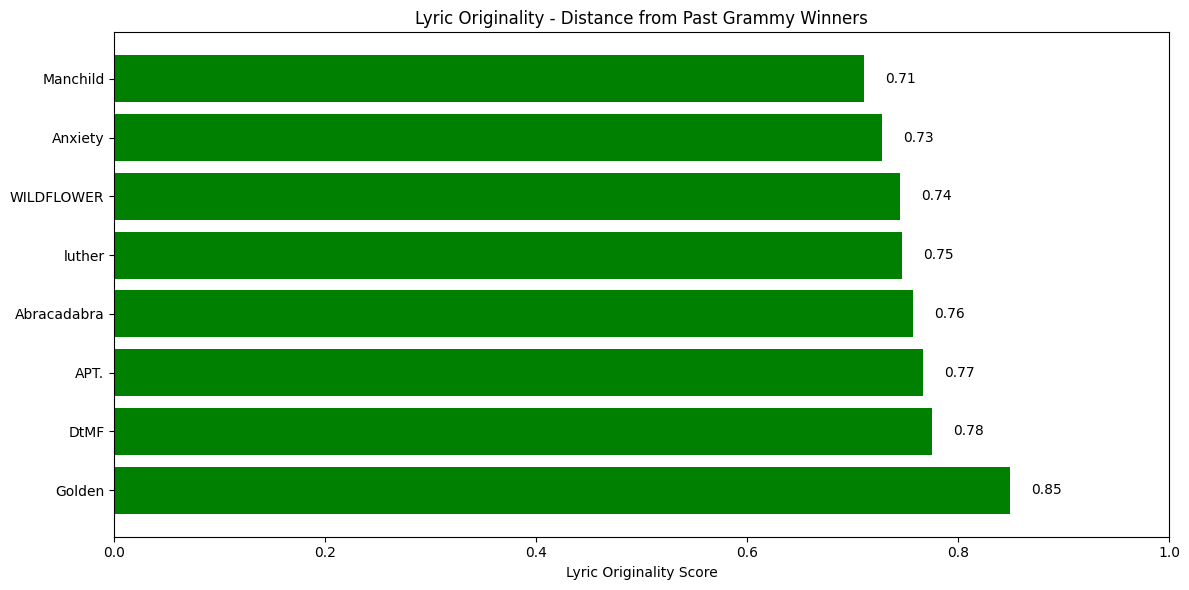

In [32]:
# Visualize originality scores
fig, ax = plt.subplots(figsize=(12, 6))

songs = orig_df['Song'].tolist()
scores = orig_df['Originality Score'].tolist()
colors = ['green' if s > 0.6 else 'gold' if s > 0.4 else 'red' for s in scores]

bars = ax.barh(songs, scores, color=colors)
ax.set_xlabel('Lyric Originality Score')
ax.set_title('Lyric Originality - Distance from Past Grammy Winners')
ax.set_xlim(0, 1)

# Add value labels
for bar, score in zip(bars, scores):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{score:.2f}', va='center')

plt.tight_layout()
plt.savefig('../data/originality_scores.png', dpi=150)
plt.show()

## 5. Word Frequency Analysis

In [33]:
# Common words across all songs
all_words = []
for song, data in all_data.items():
    lyrics = data['lyrics']['lyrics'].lower()
    # Simple tokenization
    words = [w.strip('.,!?"\'-()[]') for w in lyrics.split()]
    words = [w for w in words if len(w) > 2]  # Filter short words
    all_words.extend(words)

word_freq = Counter(all_words)
print("Most Common Words Across All Songs:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count}")

Most Common Words Across All Songs:
  you: 81
  the: 70
  아파트: 61
  it's: 37
  anxiety: 32
  que: 30
  and: 29
  like: 29
  your: 26
  abracadabra: 26
  uh-huh: 24
  keep: 23
  hear: 22
  just: 21
  i'm: 19
  all: 18
  off: 18
  tryin: 18
  better: 17
  feel: 17


In [34]:
# Unique words per song (words only in that song)
print("\nDistinctive Words by Song:")
print("="*60)

song_words = {}
for song, data in all_data.items():
    lyrics = data['lyrics']['lyrics'].lower()
    words = set([w.strip('.,!?"\'-()[]') for w in lyrics.split() if len(w) > 3])
    song_words[song] = words

for song, words in song_words.items():
    other_words = set()
    for other_song, other in song_words.items():
        if other_song != song:
            other_words.update(other)
    unique = words - other_words
    print(f"\n{song}:")
    print(f"  {', '.join(list(unique)[:10])}..." if unique else "  (no unique words)")


Distinctive Words by Song:

Golden:
  near, contributor, pathetic, house, suckers, ian, bluff, kids, rats, common...

APT.:
  whatever, 좋아하는, rosie, references, 简体中文, want, crazy, second, simplified, meet...

WILDFLOWER:
  fast, all, soft, after, experience, fell, sign, hurt, mm, “wildflower”...

Abracadabra:
  poem, “disease”, sinful, angels, firе, tongue, floor's, sing, haunting, magic...

luther:
  collaboration, froze, days, were, trust, pound, pose, heartache, marks, poppin...

Manchild:
  heard, best, a-running, not, god, manchild, blame, there's, long, innocent...

Anxiety:
  think, court, brands, ooh, caution, cutla, shine, borders, was…, somebody's...

DtMF:
  máquina, pela'o, dtmf, blanquita, estén, corazón, emborracho, tengo, foto, diablo...


## 6. Save Results

In [35]:
# Save originality scores
with open('../data/originality_scores.json', 'w') as f:
    json.dump(originality_scores, f, indent=2)

print("Saved originality_scores.json")

# Save combined lyrics analysis
combined = lyrics_df.merge(orig_df, on='Song')
combined.to_csv('../data/lyrics_analysis.csv', index=False)
print("Saved lyrics_analysis.csv")

Saved originality_scores.json
Saved lyrics_analysis.csv


## Summary

Key findings:
1. **Vocabulary Richness** - Higher values indicate more diverse word usage
2. **Originality Score** - Measures distance from past Grammy winners (higher = more unique)
3. **Distinctive Words** - Words unique to each song

**Next:** Notebook 03 - Topic Modeling & Narrative Depth